<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/solutions/conformal_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bootstrap vs conformal predictions
In this exercise we will retrieve prediction intervals for a forecaster comparing bootstrap and conformal predictions.
We will use the [ERA5-hourly](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) reanalysis dataset from Copernicus. The dataset contains forecasts from a NWP model, updated ex-post with ground truth observations.  
<center>
<img src=https://datastore.copernicus-climate.eu/c3s/published-forms-v2/c3sprod/reanalysis-era5-single-levels/overview.jpg width="300">
</center>

We retrieve the last 3 years of temperature data for a 5x5 square centered in Lugano. Since the resolution of the dataset is ~0.25 degree, the covered region is approximately the one in the figure.
<center>
<img src=https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/figs/copernicus.png
 width="300", centered=True>
</center>



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

from matplotlib import animation
from IPython.display import HTML
import matplotlib.animation as animation
from lightgbm import LGBMRegressor

In [2]:
all_dat = pd.read_pickle('https://github.com/nepslor/teaching/raw/main/TimeSeriesForecasting/data/copernicus/copernicus_dataset.zip')

In [3]:
#@title animation functions

def scatter_animation(x, y, c, n_rows=50):
    fig, ax = plt.subplots(1);

    scat = ax.scatter(x, y, c=c[0, :], s=400);


    def animate(i):
        scat.set_array(c[i, :]);
        return scat,

    def init():
        scat.set_array(c[0, :]);
        return scat,

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=n_rows, interval=100, blit=True)
    return HTML(ani.to_jshtml())

def ts_animation(y_te, y_hat, n_rows=50):
    fig, ax = plt.subplots(1);
    t = np.arange(y_hat.shape[1])
    line1, = ax.plot(y_hat[0, :], lw=2);
    line2, = ax.plot(y_te[0, :], lw=2);
    ax.set_ylim(-13, 13)
    def animate(i):
        line1.set_data(t, y_te[i, :]);
        line2.set_data(t,y_hat[i, :]);
        return (line1, line2,)

    def init():
        line1.set_data([], []);
        return (line1,)

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=n_rows, interval=100, blit=True)
    plt.close('all')
    return HTML(ani.to_jshtml())

def qs_animation(y_te, y_hat, qs, n_rows=50):
    fig, ax = plt.subplots(1);
    t = np.arange(y_hat.shape[1])
    line1, = ax.plot(y_hat[0, :], lw=2);
    line2, = ax.plot(y_te[0, :], lw=2);
    line3 = ax.plot(np.squeeze(qs[0, :, :]), 'r', lw=2, alpha=0.3);
    ax.set_ylim(-13, 13)
    def animate(i):
        line1.set_data(t, y_te[i, :]);
        line2.set_data(t, y_hat[i, :]);
        [line3[j].set_data(t, qsi) for j, qsi in enumerate(qs[i, :, :].T)];
        return (line1, line2, *line3, )

    def init():
        line1.set_data([], []);
        return (line1,)

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=n_rows, interval=100, blit=True)
    plt.close('all')
    return HTML(ani.to_jshtml())


In [ ]:
all_dat['latlong'] = all_dat['lat'] + all_dat['long']*1000
c_mat = all_dat.pivot(columns='latlong', index='time',values='T')
scatter_animation(all_dat.loc[all_dat['time']==all_dat.loc[0, 'time'], 'lat'].values,
                   all_dat.loc[all_dat['time']==all_dat.loc[0, 'time'] ,'long'].values, c=c_mat.values, n_rows=100)

In [ ]:

lagged_mav = lambda x, k: x.copy().rolling('{}d'.format(k)).mean()


target_col = 8946.0
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
filt = c_mat.index>'2022-10'
c_mat.loc[filt, [c for c in c_mat if c != target_col]].plot(alpha=0.1, ax=ax[0])
c_mat.loc[filt, target_col].plot(ax=ax[0])

c_mat_detr = pd.concat([c_mat[c]-lagged_mav(c_mat[c], 24) for c in c_mat.columns], axis=1)
c_mat_detr.loc[filt, [c for c in c_mat if c != target_col]].plot(alpha=0.1, ax=ax[1])
c_mat_detr.loc[filt, target_col].plot(ax=ax[1])
[a.legend(fontsize='xx-small', ncols=8) for a in ax]

In [6]:
class LGBM:
  """
  A simple regressor-based forecaster
  """
  def __init__(self, pars):
    self.pars = pars
    self.target_cols = None
    self.models = []

  def fit(self, x, y):
    self.target_cols = y.columns
    for c in y.columns:
        m = LGBMRegressor(**self.pars).fit(x.values, y[c].values.ravel())
        self.models.append(m)
    return self

  def predict(self, x):
    y_hat = []
    for m, c in zip(self.models, self.target_cols):
        y_hat.append(pd.Series(m.predict(x.values), index=x.index, name=c))
    return pd.concat(y_hat, axis=1)


In [7]:
def get_hankel(df, embedding=3):
  return pd.concat([df.shift(-l).rename('{}_step_{}'.format(df.name, l)) for l in range(embedding)], axis=1).iloc[:-embedding]

# create regressors
n_sa = 24
n_embedding = 26
exogenous = [c for c in c_mat if c != target_col]
x = pd.concat([get_hankel(c_mat_detr[e], embedding=n_embedding) for e in exogenous], axis=1)
target_past = get_hankel(c_mat_detr[target_col], embedding=n_embedding + n_sa).iloc[:, :n_embedding]
target_future = get_hankel(c_mat_detr[target_col], embedding=n_embedding + n_sa).iloc[:, n_embedding:]

# create dataframes with just the target and the target plus exogenous variables
df = pd.concat({'x':target_past, 'y': target_future}, axis=1)
df_ex = pd.concat({'x':pd.concat([x, target_past], axis=1), 'y': target_future}, axis=1)


In [8]:

# create training and test sets
tr_ratio = 0.6
cal_ratio = 0.2

n_tr = int(df.shape[0] * tr_ratio)
n_cal = int(df.shape[0] * cal_ratio)

x_tr, x_cal, x_te = df['x'].iloc[:-n_tr], df['x'].iloc[n_tr:n_tr+n_cal], df['x'].iloc[-n_cal:]
xex_tr, xex_cal, xex_te  = df_ex['x'].iloc[:-n_tr], df_ex['x'].iloc[n_tr:n_tr+n_cal], df_ex['x'].iloc[-n_cal:]
y_tr, y_cal, y_te = df['y'].iloc[:-n_tr], df['y'].iloc[n_tr:n_tr+n_cal], df['y'].iloc[-n_cal:]
yex_tr, yex_cal, yex_te = df_ex['y'].iloc[:-n_tr], df_ex['y'].iloc[n_tr:n_tr+n_cal], df_ex['y'].iloc[-n_cal:]


In [ ]:
# train the models
pars = {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 5}
lgbm = LGBM(pars).fit(x_tr, y_tr)
lgbm_ex = LGBM(pars).fit(xex_tr, yex_tr)
y_hat = lgbm.predict(x_te)
y_hat_ex = lgbm_ex.predict(xex_te)


In [ ]:
ts_animation(y_te.values, y_hat.values, n_rows=100)

In [ ]:
ts_animation(y_te.values, y_hat_ex.values, n_rows=100)

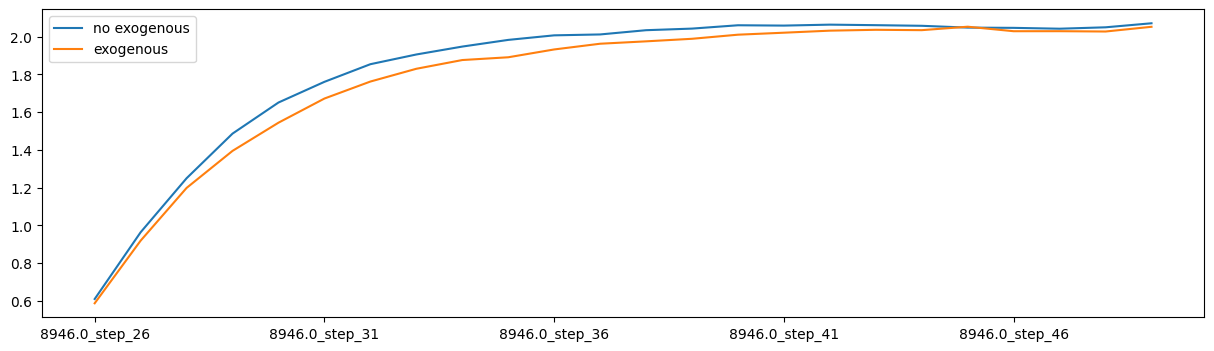

In [12]:
plt.figure(figsize=(15, 4))
(((y_te-y_hat)**2).mean()**0.5).plot(label='no exogenous')
(((y_te-y_hat_ex)**2).mean()**0.5).plot(label='exogenous')
plt.legend()

# ❓Create confidence intervals through bootstrap
Using the already obtained forecasts $\hat{y}$
1. retrieve bootstrapped prediction intervals for the forecasts.
2. use the code we've seen in the last lesson to compute the CRPS and the reliability of the forecasts


In [ ]:
y_hat = lgbm.predict(x_tr)
y = y_tr.copy()
err = y.values-y_hat.values

q_vect = np.arange(11)/10

# retrieve quantiles of the errors on the training set
q_errs = np.quantile(err, q_vect, axis=0).T

# sum quantiles to the pointwise predictions
qs = np.expand_dims(y_hat, 2) + np.expand_dims(q_errs, 0)

In [ ]:
qs_animation(y_tr.values, y_hat.values, qs)

In [ ]:
def quantile_score(q, y, q_vect=np.arange(11)/10):
  qs = {}
  for i, tau in enumerate(q_vect):
    err_tau = q[:, :, i] - y
    I = (err_tau > 0).astype(int)
    qs[tau] = np.mean((I - tau) * err_tau)
  return qs

def reliability(q, y, q_vect=np.arange(10)/10):
  res = {}
  for i, tau in enumerate(q_vect):
    res[tau] = np.mean(y < q[:, :, i])
  return res

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
pd.DataFrame(quantile_score(qs, y), index=['quantile_loss']).T.plot(ax=ax[0])
pd.DataFrame(reliability(qs, y), index=['reliability']).T.plot(ax=ax[1])
ax[1].plot([0, 1], [0, 1], linestyle='--', color='r')


# ❓ Create confidence intervals with conformal prediction
Assuming that we use the absolute forecast error as non-conformity score
1. obtain the conformal prediction intervals using the calibration set $\mathcal{D}_{cal}$.
2. Compute the CRSP and the reliabilty
3. There should be an obvious trade off between the performances of bootstrap and the conformal prediction, as a function of the size of the training/calibration sets ratio: the bigger the calibration set, the more reliable the prediction intervals of CP. At the same time, the model will be trained on less data, producing worse prediction. Try to see if you can see this effect.